In [1]:
# Purpose: Plotting the zonal mean and zonally-integrated heat uptake, 
#          sea surface temperature, surface air temperature, downward longwave
#          and downward shortwave radiation trends
#          - heat uptake from the simulations with full forcing, wind- and 
#            thermal-only forcing
#          - same for SSTs
#          - SAT, RLDS and RSDS from the JRA55-do-1-3 input fields
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 10. 12. 2021      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
base = '/g/data/e14/mv7494/access-om2/archive/'
save = '/g/data/e14/mv7494/HeatDist_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import cmocean as cm
from datetime import datetime # package for printing time in plot                                       
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
import cartopy.crs as ccrs # for maps     
import itertools
import cosima_cookbook as cc
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.feature as cfeature
from matplotlib import gridspec
from matplotlib.patches import Rectangle
import matplotlib.patheffects as PathEffects
from scipy import stats
from wrf import to_np # conversion to arrays required for arrows on maps                                

import warnings
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import cftime


from cdo import *
cdo = Cdo()
import os
import sys

# for displaying multiple output in one cell
from IPython.display import display as dp

# colours                                                                                               
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

from dask.distributed import Client
client = Client(n_workers=16)
client

Client Scheduler: tcp://127.0.0.1:45763 Dashboard: /proxy/33095/status,Cluster Workers: 16 Cores: 16 Memory: 80.00 GiB


### Load in the data for the panels

In [2]:
%%time
# ---------------------------------------------------------------- #
exp = ['_PI_Offset_','_Wind_PI_Offset_','_TempRad_PI_Offset_']
out    = '1deg_jra55_iaf_branch2000_trend/'
qnet_fn = 'trend_net_sfc_heating_average_DT_iaf'
start_time = ['1972']; end_time = ['2017']
siconca = xr.open_dataset('/g/data/e14/mv7494/jra55-do/'+'siconca_jra55-do_mask.nc').siconca_jra_mask # mask with sea ice concentration > 15% 
ocean_grid = xr.open_dataset(base+'1deg_jra55_iaf_branch2000_PI_Offset/output200/ocean/ocean_grid.nc')
dxt_ACCESS = ocean_grid.dxt; dyt_ACCESS = ocean_grid.dyt
# --- create JRA55-do dxt --------------------------------------------------- #
res = [320,640] # resolution of grid (lat: 320, lon: 640)
dxt_JRA = np.full(res[0], (6371e3*2*np.pi)/res[0]) # half the circumference of the Earth divided by number of lat grids
dyt_JRA = np.full(res[1], (6371e3*np.pi)/res[1])   # circumference of the Earth divided by the number of lon grid cells
a = np.linspace(-np.pi/2, np.pi/2,res[0])
for l in range(res[0]):
    dxt_JRA[l] = np.cos(a[l]) * dxt_JRA[l] # scale with cosine of latitude
    
# next, create ocean-only mask
tos = xr.open_dataset('/g/data/e14/mv7494/JRA55-do-1-3/land_sea_mask_320x640.nc').tos[0,:,:].fillna(0) # replace all nan with zeroes
landsea_mask = tos.where(tos>=0,1).where(tos<=0,1) # replace all non-zero data with ones
aa, bb = np.meshgrid(dyt_JRA,dxt_JRA) # create meshgrid
os.system('rm -r /g/data/e14/mv7494/ERA5/ERA5_grid.nc')
(landsea_mask*aa*bb).to_dataset(name='area_t').to_netcdf('/g/data/e14/mv7494/JRA55-do-1-3/JRA55-do-1-3_grid.nc') # JRA area
area_t_JRA = (landsea_mask*aa*bb)
dyt_JRA = (landsea_mask*aa) # create meshgrid for the two grid components
dxt_JRA = (landsea_mask*bb)
# --- create JRA55-do dxt --------------------------------------------------- #
# --------------------------------------------------------------------------- #

# ---------------------------------------------------------------- #

for f in range(3): # loop through the three simulations
    # load in Qnet spatial patterns (J m**-2 year**-1)
    Qnet = xr.open_dataset(base+out+qnet_fn+exp[f]+start_time[0]+'-'+end_time[0]+'_clim_trend_removed.nc').net_sfc_heating.squeeze() # load in spatial trend
    Qnet = (Qnet*dxt_ACCESS).sum(['xt_ocean']).rolling(yt_ocean=5, center=True).mean() # multiply with zonal grid cell length & take 10-grid cell rolling mean    
# fig = plt.figure(figsize=(13,6))
# plt.subplot(1,2,1); Qnet.plot(levels=np.linspace(-8e8,8e8,21))   
# plt.subplot(1,2,2); plt.plot((Qnet*dyt_ACCESS).sum(['xt_ocean']).rolling(yt_ocean=10, center=True).mean(),Qnet.yt_ocean)

    # load in SST (°C year**-1)
    temp_access = xr.open_dataset(base+out+'trend_temp_iaf'+exp[f]+start_time[0]+'-'+end_time[0]+'.nc').temp[0,0,:,:]
    SST_trend = (temp_access*siconca.mean('time')).mean('xt_ocean').load() # multiply with sea ice mask & take zonal mean
    
    if f == 0:
        Qnet_full = Qnet; SST_trend_full = SST_trend
    if f == 1:
        Qnet_wind = Qnet; SST_trend_wind = SST_trend
    if f == 2:
        Qnet_thermal = Qnet; SST_trend_thermal = SST_trend

# surface air temperature anomalies
tas = xr.open_mfdataset('/g/data/e14/mv7494/JRA55-do-1-3/monthly_mean/JRA55-do-1-3_tas_monthly_mean_1958-2018_detrend.nc').tas
tas = (tas.groupby('time.month') - tas.groupby('time.month').mean('time'))
tas = tas*landsea_mask # only select ocean grid cells by multiplying with landsea_mask
tas = tas.mean(['lon']).groupby('time.year').mean('time').load()
tas_zonal = np.zeros(320)
# Wall time: 3.88 s

for f in range(320): # loop through the latitudes and write out the trends
    z1 = np.polyfit(tas.year, tas[:,f], 1) # intercept and trend
    tas_zonal[f] = z1[0]
# Wall time: 16.7 s

CPU times: user 5.09 s, sys: 1.36 s, total: 6.45 s
Wall time: 19 s


### Quick check if cumulative sum over the Southern Ocean (south of 36.5°S) is the same as in Fig. 2a

In [3]:
a = np.zeros(3)
for f in range(3):
    Qnet = xr.open_dataset(base+out+qnet_fn+exp[f]+start_time[0]+'-'+end_time[0]+'_clim_trend_removed.nc').net_sfc_heating.squeeze() # load in spatial trend
    a[f] = np.round((Qnet*dxt_ACCESS*dyt_ACCESS).sum(['xt_ocean']).cumsum(['yt_ocean']).isel(yt_ocean=70)/1e21,1)
print(str(a)+' x 1e21 J/year') # yes, all good: Southern Ocean heat uptake the same as in Fig. 2a and Fig. S4a, S4e

[7.  4.1 3.2] x 1e21 J/year


### Calculate time-integrated net surface heat flux components
- SW, LW, SH, LH
- as in the script: spatial_maps_and_zonal_integral_of_accumulated_ocean_heat_content_and_net_sfc_heating_anomalies-PI_Offset.ipynb

In [4]:
%%time
base2 = '/scratch/e14/mv7494/access-om2/archive/'
run = ['1deg_jra55_iaf_Control/','1deg_jra55_iaf_branch2000/',
      '1deg_jra55_iaf_Wind/','1deg_jra55_iaf_TempRad/']
var = ['swflx','lw_heat','sens_heat','evap_heat']
exp = ['ctrl','iaf', 'wind', 'thermal']

for i in range(4): # loop through the four variables [SW, LW, SH and LH]
    for f in range(4): # loop through CTRL, IAF, Wind-only and Thermal-only runs
        print(exp[f]+': '+var[i])
        # time-integrate and save as data set
        variable = ((xr.open_mfdataset(base2+run[f]+'output2*/ocean/ocean_month.nc')[var[i]])*(60*60*24*30)).cumsum(['time']).to_dataset(name=var[i])      
        
        # delete file if it already exists, to be sure I do not mess up by potentially overwriting
        if os.path.isfile(base+out+var[i]+'_average_DT_'+exp[f]+'_'+start_time[0]+'-'+end_time[0]+'.nc') == True:
             os.system('rm -r '+base+out+var[i]+'*.nc') 
        variable.to_netcdf(base+out+var[i]+'_average_DT_'+exp[f]+'_'+start_time[0]+'-'+end_time[0]+'.nc')

        # calculate linear trend in the control
        if f == 0:
            cdo.trend(input  = base+out+var[i]+'_average_DT_'+exp[0]+'_'+start_time[0]+'-'+end_time[0]+'.nc',
                      output = base+out+'intercept_'+var[i]+'_average_DT_'+exp[0]+'_'+start_time[0]+'-'+end_time[0]+'.nc ' +
                      base+out+'trend_'+var[i]+'_average_DT_'+exp[0]+'_'+start_time[0]+'-'+end_time[0]+'.nc', force=False)
            
        if f >= 1: # only remove trend if the iteration is for the IAF run
            cdo.subtrend(input = base+out+var[i]+'_average_DT_'+exp[f]+'_'+start_time[0]+'-'+end_time[0]+'.nc '+
                         base+out+'intercept_'+var[i]+'_average_DT_'+exp[0]+'_'+start_time[0]+'-'+end_time[0]+'.nc '+
                         base+out+'trend_'+var[i]+'_average_DT_'+exp[0]+'_'+start_time[0]+'-'+end_time[0]+'.nc',
                         output= base+out+var[i]+'_average_DT_'+exp[f]+'_'+start_time[0]+'-'+end_time[0]+'_clim_trend_removed.nc', force=False)

        # creating intercept and linear trend from the residual in the step above
        # remove if files already exist
        if f >= 1:
            os.system('rm -r '+base+out+'intercept_'+var[i]+'_average_DT_'+exp[f]+'_'+start_time[0]+'-'+end_time[0]+'_clim_trend_removed.nc ' +
                      base+out+'trend_'+var[i]+'_average_DT_'+exp[f]+'_'+start_time[0]+'-'+end_time[0]+'_clim_trend_removed.nc')
            cdo.trend(input= '-yearmean -selyear,1972/2017 '+base+out+var[i]+'_average_DT_'+exp[f]+'_'+start_time[0]+'-'+end_time[0]+'_clim_trend_removed.nc',
                      output = base+out+'intercept_'+var[i]+'_average_DT_'+exp[f]+'_'+start_time[0]+'-'+end_time[0]+'_clim_trend_removed.nc '+
                      base+out+'trend_'+var[i]+'_average_DT_'+exp[f]+'_'+start_time[0]+'-'+end_time[0]+'_clim_trend_removed.nc', force=False)
        # clean up
        if exp[f] != 'iaf': # I need the 'iaf' intercept for the calculation check later on
            os.system('rm -r '+base+out+'intercept_'+var[i]+'_average_DT_'+exp[f]+'_'+start_time[0]+'-'+end_time[0]+'_clim_trend_removed.nc')
         
        if f >= 1:
            variable_map = xr.open_dataset(base+out+'trend_'+var[i]+'_average_DT_'+exp[f]+'_'+start_time[0]+'-'+end_time[0]+'_clim_trend_removed.nc')[var[i]].squeeze()
            variable_zonal = (variable_map*dxt_ACCESS).sum(['xt_ocean']).rolling(yt_ocean=5, center=True).mean()
            variable_SOint = (variable_map*dxt_ACCESS*dyt_ACCESS).sum(['xt_ocean']).cumsum('yt_ocean').isel(yt_ocean=70)
            
        if f >=1 and var[i] == 'swflx': 
            if exp[f] == 'iaf':
                swflx_zonal_iaf = variable_zonal
                swflx_SOint_iaf = variable_SOint
            if exp[f] == 'wind':
                swflx_zonal_wind = variable_zonal 
                swflx_SOint_wind = variable_SOint
            if exp[f] == 'thermal':
                swflx_zonal_thermal = variable_zonal
                swflx_SOint_thermal = variable_SOint
        if f >=1 and var[i] == 'lw_heat': 
            if exp[f] == 'iaf':
                lw_heat_zonal_iaf = variable_zonal
                lw_heat_SOint_iaf = variable_SOint
            if exp[f] == 'wind':
                lw_heat_zonal_wind = variable_zonal 
                lw_heat_SOint_wind = variable_SOint
            if exp[f] == 'thermal':
                lw_heat_zonal_thermal = variable_zonal 
                lw_heat_SOint_thermal = variable_SOint
        if f >=1 and var[i] == 'sens_heat': 
            if exp[f] == 'iaf':
                sens_heat_zonal_iaf = variable_zonal
                sens_heat_SOint_iaf = variable_SOint
            if exp[f] == 'wind':
                sens_heat_zonal_wind = variable_zonal
                sens_heat_SOint_wind = variable_SOint
            if exp[f] == 'thermal':
                sens_heat_zonal_thermal = variable_zonal
                sens_heat_SOint_thermal = variable_SOint
        if f >=1 and var[i] == 'evap_heat': 
            if exp[f] == 'iaf':
                evap_heat_zonal_iaf = variable_zonal
                evap_heat_SOint_iaf = variable_SOint
            if exp[f] == 'wind':
                evap_heat_zonal_wind = variable_zonal 
                evap_heat_SOint_wind = variable_SOint
            if exp[f] == 'thermal':
                evap_heat_zonal_thermal = variable_zonal 
                evap_heat_SOint_thermal = variable_SOint
# Wall time: 1min 29s

ctrl: swflx
iaf: swflx
wind: swflx
thermal: swflx
ctrl: lw_heat
iaf: lw_heat
wind: lw_heat
thermal: lw_heat
ctrl: sens_heat
iaf: sens_heat
wind: sens_heat
thermal: sens_heat
ctrl: evap_heat
iaf: evap_heat
wind: evap_heat
thermal: evap_heat
CPU times: user 19.4 s, sys: 5.58 s, total: 24.9 s
Wall time: 1min 41s


### Summary of fluxes integrated over the Southern Ocean

In [28]:
np.round(np.array([swflx_SOint_iaf.values, lw_heat_SOint_iaf.values, sens_heat_SOint_iaf.values, evap_heat_SOint_iaf.values])/1e21,1)

array([-0.7,  3.2,  3. ,  0.3])

In [30]:
np.round(np.array([swflx_SOint_wind.values, lw_heat_SOint_wind.values, sens_heat_SOint_wind.values, evap_heat_SOint_wind.values])/1e21,1)

array([-0.1,  1.8,  3.2, -2.2])

In [29]:
np.round(np.array([swflx_SOint_thermal.values, lw_heat_SOint_thermal.values, sens_heat_SOint_thermal.values, evap_heat_SOint_thermal.values])/1e21,1)

array([-1.2,  3.5,  2. , -2.2])

### Quick check if all surface heat flux components looks okay

# Note, Wind-only and Thermal-only simulations not yet finished

Text(0.5, 0, '(10$^{15}$ J year$^{-1}$)')

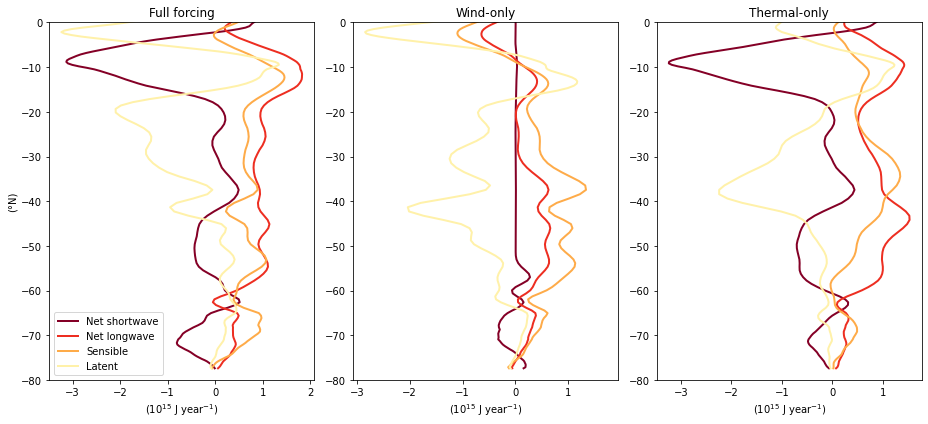

In [8]:
fig = plt.figure(figsize=(13,6),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(1,3, width_ratios=[1,1,1]); cmap = plt.cm.get_cmap('YlOrRd')

ax1 = plt.subplot(gs[0,0])
plt.plot(swflx_zonal_iaf/1e15,         swflx_zonal_iaf.yt_ocean,    linewidth=2, color=cmap(.99), label='Net shortwave')
plt.plot(lw_heat_zonal_iaf/1e15,     lw_heat_zonal_iaf.yt_ocean,    linewidth=2, color=cmap(.7), label='Net longwave')
plt.plot(sens_heat_zonal_iaf/1e15, sens_heat_zonal_iaf.yt_ocean,  linewidth=2, color=cmap(.4), label='Sensible')
plt.plot(evap_heat_zonal_iaf/1e15, evap_heat_zonal_iaf.yt_ocean,  linewidth=2, color=cmap(.1), label='Latent')
plt.title('Full forcing'); plt.ylim([-80,0]); plt.legend(); plt.xlabel('(10$^{15}$ J year$^{-1}$)'); plt.ylabel('(°N)')

ax1 = plt.subplot(gs[0,1])
plt.plot(swflx_zonal_wind/1e15,         swflx_zonal_iaf.yt_ocean,    linewidth=2, color=cmap(.99), label='Net shortwave')
plt.plot(lw_heat_zonal_wind/1e15,     lw_heat_zonal_iaf.yt_ocean,    linewidth=2, color=cmap(.7), label='Net longwave')
plt.plot(sens_heat_zonal_wind/1e15, sens_heat_zonal_iaf.yt_ocean,  linewidth=2, color=cmap(.4), label='Sensible')
plt.plot(evap_heat_zonal_wind/1e15, evap_heat_zonal_iaf.yt_ocean,  linewidth=2, color=cmap(.1), label='Latent'); plt.title('Wind-only'); plt.ylim([-80,0]); plt.xlabel('(10$^{15}$ J year$^{-1}$)')

ax1 = plt.subplot(gs[0,2])
plt.plot(swflx_zonal_thermal/1e15,         swflx_zonal_iaf.yt_ocean,    linewidth=2, color=cmap(.99), label='Net shortwave')
plt.plot(lw_heat_zonal_thermal/1e15,     lw_heat_zonal_iaf.yt_ocean,    linewidth=2, color=cmap(.7), label='Net longwave')
plt.plot(sens_heat_zonal_thermal/1e15, sens_heat_zonal_iaf.yt_ocean,  linewidth=2, color=cmap(.4), label='Sensible')
plt.plot(evap_heat_zonal_thermal/1e15, evap_heat_zonal_iaf.yt_ocean,  linewidth=2, color=cmap(.1), label='Latent'); plt.title('Thermal-only'); plt.ylim([-80,0]); plt.xlabel('(10$^{15}$ J year$^{-1}$)')


### Load in downward radiation data from JRA55-do-1-3

In [9]:
# %%time

# base_jra = '/g/data/e14/mv7494/JRA55-do-1-3/monthly_mean/'
# exp='JRA55-do'
# var = ['rlds','rsds']

# for i in range(2): # loop through rlds and rsds
#     print(var[i])
#     # time-integrate and save as data set
#     # monthly mean data created by :history = "Thu Oct 28 21:29:24 2021: cdo -O -monmean -mergetime from the raw JRA55-do data set
#     variable = xr.open_mfdataset(base_jra+'JRA55-do-1-3_'+var[i]+'_monthly_mean_1958-2018.nc')[var[i]]
#     variable = (variable*(60*60*24*30)*landsea_mask).cumsum(['time']).to_dataset(name=var[i])

#     # delete file if it already exists, to be sure I do not mess up by potentially overwriting
#     if os.path.isfile(base+out+'trend_'+var[i]+'_average_DT_anoms_'+exp+'_'+start_time[0]+'-'+end_time[0]+'.nc') == True:
#         os.system('rm -r '+base+out+var[i]+'*.nc')
#         os.system('rm -r '+base+out+'intercept_'+var[i]+'*.nc')
#         os.system('rm -r '+base+out+'trend_'+var[i]+'*.nc')
#     # variable.to_netcdf(base+out+var[i]+'_average_DT_'+exp+'_'+start_time[0]+'-'+end_time[0]+'.nc')
#     # os.system('rm -r '+base+out+var[i]+'_average_DT_anoms_'+exp+'_'+start_time[0]+'-'+end_time[0]+'.nc') 
    

#     # cdo.yseassub(input = f1 +' -yseasavg -selyear,1958/1988 ' + f1, output = f2, force=False)
#     # cdo.yseassub(input = base+out+var[i]+'_average_DT_'+exp+'_'+start_time[0]+'-'+end_time[0]+'.nc' + ' -yseasavg -selyear,1958/1988 '+
#     #              base+out+var[i]+'_average_DT_'+exp+'_'+start_time[0]+'-'+end_time[0]+'.nc',
#     #              output = base+out+var[i]+'_average_DT_anoms_'+exp+'_'+start_time[0]+'-'+end_time[0]+'.nc', force=True)
    
#     # # calculate anomalies
#     (variable.groupby('time.month') - variable.groupby('time.month').mean('time'))[var[i]].drop('month').to_netcdf(
#         base+out+var[i]+'_average_DT_anoms_'+exp+'_'+start_time[0]+'-'+end_time[0]+'.nc') # save as netcdf file
#     # Wall time: 36.7 s
#     cdo.trend(input  = '-yearmean -selyear,1972/2017 '+base+out+var[i]+'_average_DT_anoms_'+exp+'_'+start_time[0]+'-'+end_time[0]+'.nc',
#               output = base+out+'intercept_'+var[i]+'_average_DT_anoms_'+exp+'_'+start_time[0]+'-'+end_time[0]+'.nc '+
#               base+out+'trend_'+var[i]+'_average_DT_anoms_'+exp+'_'+start_time[0]+'-'+end_time[0]+'.nc', force=True)
# # Wall time: 1min 2s

In [10]:
# rlds = xr.open_dataset(base+out+'trend_'+var[0]+'_average_DT_anoms_'+exp+'_'+start_time[0]+'-'+end_time[0]+'.nc')[var[0]].squeeze()
# rsds = xr.open_dataset(base+out+'trend_'+var[1]+'_average_DT_anoms_'+exp+'_'+start_time[0]+'-'+end_time[0]+'.nc')[var[1]].squeeze()
# plt.figure(figsize=(12,4));plt.suptitle('RLDS and RSDS trends, 1972-2017 (J m$^{-2}$ year$^{-1}$)'); ticks=np.linspace(0,8e8,21)
# plt.subplot(1,2,1); rlds.plot(); plt.title(''); plt.subplot(1,2,2); rsds.plot(); plt.title('')

In [11]:
# rlds_zonal3 = (rlds*dxt_JRA).sum(['lon']) # multiply by 12 to get the annual linear trend from the monthly trend
# rsds_zonal3 = (rsds*dxt_JRA).sum(['lon'])

# cmap = plt.cm.get_cmap('YlOrRd')
# plt.plot(swflx_zonal_iaf/1e15,   swflx_zonal_iaf.yt_ocean,    linewidth=2, color=cmap(.99), label='Net shortwave')
# plt.plot(lw_heat_zonal_iaf/1e15, swflx_zonal_iaf.yt_ocean,    linewidth=2, color=cmap(.7), label='Net longwave')
# # interpolated time series = np.interp(target length, original length, original data)

# plt.plot(rsds_zonal3/1e15, rsds.lat,  linewidth=2, color=cmap(.99), label='Down shortwave', linestyle='--')
# plt.plot(rlds_zonal3/1e15, rlds.lat,  linewidth=2, color=cmap(.7), label='Down longwave', linestyle='--'); plt.legend()

In [12]:
# %%time
# base_jra = '/g/data/e14/mv7494/JRA55-do-1-3/monthly_mean/'
# # monthly mean data created by :history = "Thu Oct 28 21:29:24 2021: cdo -O -monmean -mergetime from the raw JRA55-do data set
# rlds = xr.open_dataset(base_jra+'JRA55-do-1-3_rlds_monthly_mean_1958-2018.nc').rlds.sel(time=slice('1972','2017')) 
# rsds = xr.open_dataset(base_jra+'JRA55-do-1-3_rsds_monthly_mean_1958-2018.nc').rsds.sel(time=slice('1972','2017'))

# # only select flux over ocean, multiply with grid-cell zonal length & convert to J/m2 by multiplying with the number of seconds per month
# rlds = (rlds*landsea_mask*60*60*24*30).cumsum(['time'])
# rlds = (rlds.groupby('time.month') - rlds.groupby('time.month').mean('time')) # calculate anomalies


# # rlds = xr.open_dataset('/g/data/e14/mv7494/JRA55-do-1-3/trend.nc').squeeze().rlds
# rlds = (rlds*dxt_JRA).sum(['lon'])
# # plt.plot(rlds_zonal,rlds.lat)

# rsds = (rsds*landsea_mask*60*60*24*30).cumsum(['time'])
# rsds = (rsds.groupby('time.month') - rsds.groupby('time.month').mean('time'))
# rsds = (rsds*dxt_JRA).sum(['lon'])

# time = np.linspace(1972,2017,552) # I cannot use the rlds.time dimension as I get an error otherwise
# rlds_zonal = np.zeros(320); rsds_zonal = np.zeros(320) # empty arrays which get filled up with the trends
# for f in range(320): # loop through each latitude
#     if f % 50 == 0:
#         print('latitude '+str(f))
#     z1 = np.polyfit(time, rlds[:,f], 1) # calculate linear trend
#     rlds_zonal[f] = z1[0] * 12 # multiply by 12 to get annual trend instead of monthly trend and write into empty array
#     z1 = np.polyfit(time, rsds[:,f], 1)
#     rsds_zonal[f] = z1[0] * 12
# # Wall time: 11.2 s

### Plotting routine

CPU times: user 1.11 s, sys: 116 ms, total: 1.23 s
Wall time: 1.1 s


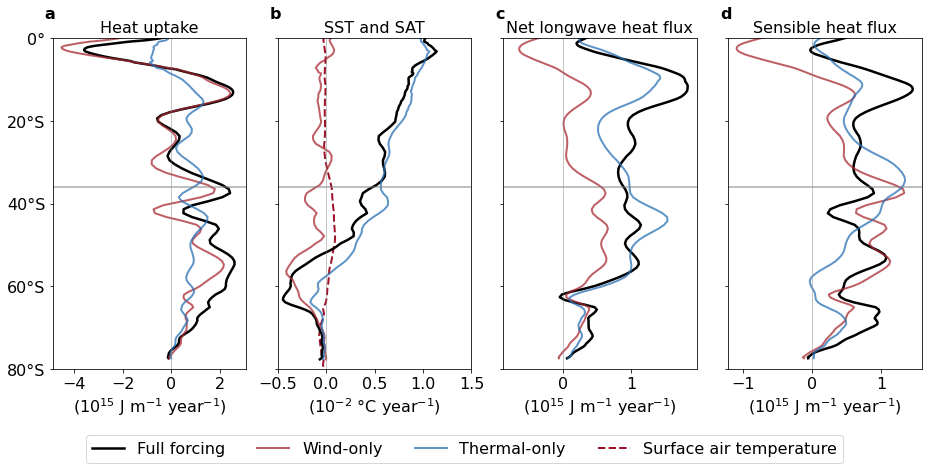

In [13]:
%%time
# initialise figure
fig = plt.figure(figsize=(13,6),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(1,4, width_ratios=[1,1,1,1]) 
ylimit = [-80, 0] 

def fancy_panels(titel, xlab, panel_nr):
    # ax1.set_xlim(xlimit[0],xlimit[1])
    ax1.axvline(x=0, c = 'grey', linewidth = .5, alpha = .9); ax1.axhline(y=-36, c = 'grey', linewidth = 2, alpha=.5)
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    plt.locator_params(axis='x', nbins=5);
    # ---
    # legend including a legend title
    # plt.legend(fontsize=16, ncol=1)#, bbox_to_anchor=(.99, .05), loc='lower right') 
    plt.title(titel,fontsize=16)

    ax1.text(-.04, 1.06,panel_nr, transform=ax1.transAxes, size=16, weight='bold') # bold letter at the top
    ax1.set_xlabel(xlab, fontsize=16)
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)

    ax1.set_ylim(ylimit[0],ylimit[1])
    ax1.locator_params(axis='x', nbins=5)
    ax1.locator_params(axis='y', nbins=7)

    labels = [item.get_text() for item in ax1.get_yticklabels()]     
    ax1.set_yticklabels(['80°S','60°S','40°S','20°S','0°'], fontsize=16)  
    # plt.legend(fontsize=16)

# panel 1: heat uptake data ----------------------------------------------------------------------------- 
ax1 = plt.subplot(gs[0,0]); xlimit = [-5,3] 

plt.plot(Qnet_full/1e15,Qnet_full.yt_ocean, linewidth=2.5, color='k', label='Full forcing')
plt.plot(Qnet_wind/1e15,Qnet_full.yt_ocean, linewidth=2, color=rotblau[3], label='Wind-only', alpha=.75)
plt.plot(Qnet_thermal/1e15,Qnet_full.yt_ocean, linewidth=2, color=rotblau[17], label='Thermal-only', alpha=.75)


# ax1.set_xlim(xlimit[0],xlimit[1])
# plt.text(-4.5,-20,'10-grid cell\nrolling mean',fontsize=16,color='grey')

fancy_panels('Heat uptake','(10$^{15}$ J m$^{-1}$ year$^{-1}$)','a')
# plt.plot(np.zeros(1), np.zeros([1]), color='w', alpha=0, label=' ') # add empty dummy legend items
# plt.legend(ncol=1,fontsize=16, bbox_to_anchor=(.32, .3), loc='center')

# panel 2: temperature data ----------------------------------------------------------------------------- 
ax1 = plt.subplot(gs[0,1]); xlimit = [-.5,1.5] 
plt.plot(tas_zonal*1e2, tas.lat,  linewidth=2, color=rotblau[2], label = 'Surface air temperature', linestyle='--')            
plt.plot(SST_trend_full*1e2,SST_trend_full.yt_ocean, linewidth=2.5, color='k')
plt.plot(SST_trend_wind*1e2,SST_trend_full.yt_ocean, linewidth=2, color=rotblau[3], alpha=.75)
plt.plot(SST_trend_thermal*1e2,SST_trend_full.yt_ocean, linewidth=2, color=rotblau[17], alpha=.75)

ax1.set_xlim(xlimit[0],xlimit[1])

fancy_panels('SST and SAT','(10$^{-2}$ °C year$^{-1}$)','b')
ax1.set_yticklabels([]) # no labels because I already have those on the left
# plt.legend(ncol=1,fontsize=16, bbox_to_anchor=(.72, .2), loc='center') 

# panel 3: radiation data ----------------------------------------------------------------------------- 
ax1 = plt.subplot(gs[0,2]); xlimit = [-.15,.15] 
cmap = plt.cm.get_cmap('YlOrRd')

# only plotting SENSIBLE HEAT FLUX and NET LONGWAVE for now
plt.plot(lw_heat_zonal_iaf/1e15,     lw_heat_zonal_iaf.yt_ocean,    linewidth=2.5, color='k')
plt.plot(lw_heat_zonal_wind/1e15,     lw_heat_zonal_iaf.yt_ocean,    linewidth=2, color=rotblau[3], alpha=.75)
plt.plot(lw_heat_zonal_thermal/1e15,     lw_heat_zonal_iaf.yt_ocean,    linewidth=2, color=rotblau[17], alpha=.75)


# plt.plot(evap_heat_zonal/1e15, evap_heat_zonal.yt_ocean,  linewidth=2, color=cmap(.1), label='Latent')
# plt.plot(swflx_zonal/1e15,         swflx_zonal.yt_ocean,    linewidth=2, color=cmap(.99), label='Net shortwave')
# plt.plot((swflx_zonal+lw_heat_zonal+sens_heat_zonal+evap_heat_zonal)/1e15, swflx_zonal.yt_ocean,  linewidth=2, color='grey', alpha=.5)
# plt.text(1,-23,'Total',fontsize=16,color='grey', ha='left', alpha=.5)
# plt.plot(rlds_zonal3/1e15, rlds.lat,  linewidth=2, color=cmap(.99), label='Down longwave')
# plt.plot(rsds_zonal3/1e15, rsds.lat,  linewidth=2, color=cmap(.7), label='Down shortwave')
# ax1.set_xlim(xlimit[0],xlimit[1])

fancy_panels('Net longwave heat flux','(10$^{15}$ J m$^{-1}$ year$^{-1}$)', 'c')
ax1.set_yticklabels([]) # no labels because I already have those on the left

# panel 3: radiation data ----------------------------------------------------------------------------- 
ax1 = plt.subplot(gs[0,3]); xlimit = [-.15,.15] 
cmap = plt.cm.get_cmap('YlOrRd')

# only plotting SENSIBLE HEAT FLUX and NET LONGWAVE for now

plt.plot(sens_heat_zonal_iaf/1e15, sens_heat_zonal_iaf.yt_ocean,  linewidth=2.5, color='k')
plt.plot(sens_heat_zonal_wind/1e15, sens_heat_zonal_iaf.yt_ocean,  linewidth=2, color=rotblau[3], alpha=.75)
plt.plot(sens_heat_zonal_thermal/1e15, sens_heat_zonal_iaf.yt_ocean,  linewidth=2, color=rotblau[17], alpha=.75)


fancy_panels('Sensible heat flux','(10$^{15}$ J m$^{-1}$ year$^{-1}$)', 'd')
ax1.set_yticklabels([]) # no labels because I already have those on the left

fig.legend(ncol=4,fontsize=16, bbox_to_anchor=(.5, -.1), loc='lower center') 

# --------------------------------------------------------------------------- #
# --- saving as 300 dpi .PNG image in specified folder ---------------------- #
# --- end of script --------------------------------------------------------- #
plt.savefig(save + 'Zonal_forcing_and_SST_trends', 
            dpi=300, facecolor='w',
            edgecolor='w', orientation='landscape', papertype=None, 
            format=None, transparent=False, bbox_inches='tight', 
            pad_inches=0.1, metadata=None)
# --- end of script --------------------------------------------------------- #
# Wall time: 20.6 s

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #